In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

import pandas as pd

from datetime import datetime

from rich import print
from rich.console import Console
from rich.traceback import install

install(show_locals=True)
console = Console()

#### Carga de datos

Primero cargamos los datos de la base de datos de transacciones fraudulentas, que se encuentra en el archivo `./data/creditcard.csv`.` Podemos ver que que lo componen 31 atributos (columnas) y 284.807 objetos (filas).

In [3]:
cc_df = pd.read_csv('./data/creditcard.csv')

(n_samples, n_features) = cc_df.shape

print(f"n_samples: {n_samples}, n_features: {n_features}")

n_samples: 284807, n_features: 31

#### Preprocesamiento

##### Balanceamiento

En esta fase debido a que el atributo clase 'Class' esta extremadamente desbalanceada, para que los modelos sean consistentes con los resultados, balanceamos dicho atributo dando como resultado una nueva matriz de 568.630 objetos.
En la tabla de resultados se pueden ver que efectivamente esta balanceada.

In [4]:
FEATURES = cc_df.drop(['Class'], axis=1) # Features
TARGET = cc_df['Class']                  # Target

smote = SMOTE(random_state=42) # Crea un objeto SMOTE con semilla 42
X_sm, y_sm = smote.fit_resample(FEATURES, TARGET)

cc_balanced = pd.concat([pd.DataFrame(X_sm), pd.DataFrame(y_sm)], axis=1)

print('Valores de la columna Class:')
cc_balanced['Class'].describe()

Valores de la columna Class:

count    568630.0
mean          0.5
std           0.5
min           0.0
25%           0.0
50%           0.5
75%           1.0
max           1.0
Name: Class, dtype: float64

Miramos qué atributos podemos eliminar analizando la matriz de correlación. A partir de esa matriz, vemos que hay muchos atributos con elevada correlación, por lo que fijamos un umbral = 0.88 e imprimimos los atributos por encima de ese valor

In [14]:
data_corr = cc_balanced.corr()

for i in range(len(cc_balanced.columns)):
    for j in range(i):
        if abs(data_corr.iloc[i, j]) > 0.88:
            print(data_corr.columns[i], data_corr.columns[j], data_corr.iloc[i, j])

V17 V12 0.8813298872699556

Eliminamos los atributos expuestos

In [6]:
cc_balanced = cc_balanced.drop(['V1', 'V7', 'V10', 'V11', 'V14', 'V16', 'V18'], axis = 1)

##### Normalización

Como último paso de preprocesaminento, normalizamos los datos para que estén dentro de un estándar

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


cc_balanced.iloc[:,0:-1] = scaler.fit_transform(cc_balanced.iloc[:,0:-1].to_numpy())
cc_balanced.to_pickle('./pickled/cc_prep_final.pkl')

Para el modelaje, hemos separado los datos en 50% entrenamiento, 25% validación y 25% test 

Podemos observar los resultados de cada parte

In [8]:
from traceback import print_tb


df_prep = pd.read_pickle('./pickled/cc_prep_final.pkl')

TARGET = df_prep['Class']
FEATURES = df_prep.drop(['Class'], axis=1)

features_train, features_aux, target_train, target_aux = train_test_split(FEATURES, TARGET, test_size=0.5, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(features_aux, target_aux, test_size=0.5, random_state=42)

print(f'features_train: {features_train.shape}')
print(f'features_valid: {features_valid.shape}')
print(f'features_test: {features_test.shape}')
print(f'target_train: {target_train.shape}')
print(f'target_valid: {target_valid.shape}')
print(f'target_test: {target_test.shape}')
print(f'features_train: {features_train.shape}')
print(f'features_valid: {features_valid.shape}')
print(f'features_test: {features_test.shape}')

features_train: (284315, 23)

features_valid: (142157, 23)

features_test: (142158, 23)

target_train: (284315,)

target_valid: (142157,)

target_test: (142158,)

features_train: (284315, 23)

features_valid: (142157, 23)

features_test: (142158, 23)

#### Resultados iniciales Perceptrón Simple

Entrenamos nuestro modelo Perceptrón Simple con 30 iteraciones (como máximo), que nos dará la medida de hasta que punto el problema es separable linelamente.

In [9]:
# # Modeling Perceptron
# # ------------
max_iter = 30

print("Learning a Perceptron with %d maximum number of iterations and ..." % max_iter)

per = Perceptron(max_iter=30, shuffle=False, verbose=True)
per.fit(features_train, target_train)

# Results
print("Printing Perceptron results")

predict_train = per.predict(features_train)
predict_valid = per.predict(features_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print(confusion_matrix(target_valid, predict_valid))
print(classification_report(target_valid, predict_valid))

Learning a Perceptron with 30 maximum number of iterations and ...

-- Epoch 1
Norm: 36.03, NNZs: 23, Bias: 27.000000, T: 284315, Avg. loss: 0.726561
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 38.76, NNZs: 23, Bias: 29.000000, T: 568630, Avg. loss: 0.722691
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 37.04, NNZs: 23, Bias: 30.000000, T: 852945, Avg. loss: 0.684831
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 39.96, NNZs: 23, Bias: 31.000000, T: 1137260, Avg. loss: 0.710641
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 38.95, NNZs: 23, Bias: 32.000000, T: 1421575, Avg. loss: 0.697668
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 35.50, NNZs: 23, Bias: 26.000000, T: 1705890, Avg. loss: 0.734759
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 36.28, NNZs: 23, Bias: 27.000000, T: 1990205, Avg. loss: 0.729476
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 36.37, NNZs: 23, Bias: 29.000000, T: 2274520, Avg. loss: 0.696988
Total training time: 0.10 seconds.
Convergence after 8 epochs took 0.10 seconds


Printing Perceptron results

Train accuracy: 92.937%

Valid accuracy: 92.921%

[[65367  5759]
 [ 4305 66726]]

precision    recall  f1-score   support

           0       0.94      0.92      0.93     71126
           1       0.92      0.94      0.93     71031

    accuracy                           0.93    142157
   macro avg       0.93      0.93      0.93    142157
weighted avg       0.93      0.93      0.93    142157

Se observa que el problema no es separable linealmente, aunque los resultados aparentan ser buenos dado las imágenes vistas.

#### Resultados iniciales MLP

Se define la función MLP_train_valid para poder realizar entrenamientos del Perceptrón Multicapa (MLP) incluyendo validaciones con el conjunto de validación y early stopping, así como mostrar opcionalmente resultados y logs:

In [10]:
# Modeling MLP
# ------------
# Function to training and validate MLP
def MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, verbose):
    """
    Train and valid MLP every valid_cycles iterations
    """
    classes  = np.unique(target_train)
    loss_valid = []
    for i in range(max_iter//valid_cycles):
        for _ in range(valid_cycles):
            out = mlp.partial_fit(input_train, target_train, classes)
        last_lost_valid = log_loss(target_valid, mlp.predict_proba(input_valid))
        loss_valid.append(last_lost_valid)
        if verbose:
            print("Iteration %d, train loss = %.8f, valid loss = %.8f" %
                  (mlp.n_iter_, mlp.loss_, last_lost_valid))
        if early_stopping and (i > 0) and (last_lost_valid > loss_valid[-2]): # Early stopping
            if verbose:
                print("Early stopping: Validation score did not improve")
            break
    if verbose: print(out)

    if verbose:
        MLP_print_verbose(mlp, valid_cycles, loss_valid)


def MLP_print_verbose(mlp, valid_cycles, loss_valid):
    print("Visualizing the Cost Function Trajectory")
    plt.plot(range(1, len(mlp.loss_curve_)+1), mlp.loss_curve_, label='Train loss')
    plt.plot(range(valid_cycles,len(loss_valid)*valid_cycles+valid_cycles,valid_cycles), loss_valid, '-o', label='Valid loss')
    plt.xlabel('number of iterations')
    plt.ylabel('loss function')
    plt.legend(loc='upper right')
    plt.show()

 Se realiza un entrenamiento con un MLP de una capa oculta de 60 neuronas, un ratio de aprendizaje de 0,001, durante un máximo 300 iteraciones, validando cada 5 ciclos. Se muestra la gráfica de la evolución del error a lo largo de los ciclos.

Learning a MLP with 60 hidden neurons, 300 maximum number of iterations and 0.00100000 
learning rate ...

Iteration 5, train loss = 0.02855719, valid loss = 0.02656797

Iteration 10, train loss = 0.01249381, valid loss = 0.01226944

Iteration 15, train loss = 0.00743824, valid loss = 0.00768098

Iteration 20, train loss = 0.00517617, valid loss = 0.00567072

Iteration 25, train loss = 0.00390451, valid loss = 0.00460331

Iteration 30, train loss = 0.00309243, valid loss = 0.00391699

Iteration 35, train loss = 0.00257435, valid loss = 0.00364810

Iteration 40, train loss = 0.00220819, valid loss = 0.00329012

Iteration 45, train loss = 0.00193658, valid loss = 0.00319780

Iteration 50, train loss = 0.00171545, valid loss = 0.00300314

Iteration 55, train loss = 0.00154324, valid loss = 0.00289308

Iteration 60, train loss = 0.00140724, valid loss = 0.00289578

Early stopping: Validation score did not improve

MLPClassifier(hidden_layer_sizes=60, random_state=0, shuffle=False)

Visualizing the Cost Function Trajectory

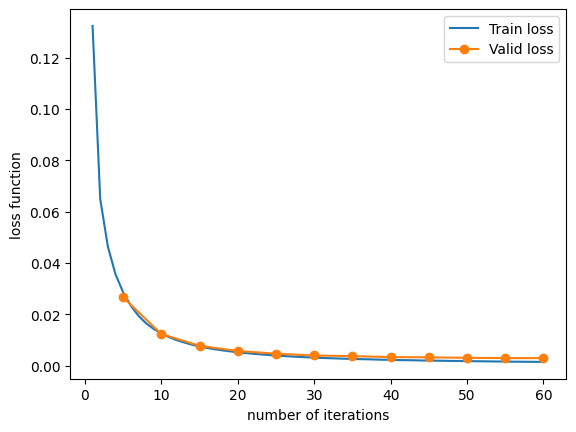

In [11]:
from sklearn.neural_network import MLPClassifier

# Multilayer Percetron wiht n_hidden hidden neurons
n_hidden = 60
max_iter = 300
learning_rate_init = 0.001
valid_cycles = 5
early_stopping = True

print("Learning a MLP with %d hidden neurons, %d maximum number of iterations and %.8f learning rate ..." % (n_hidden, max_iter, learning_rate_init))

mlp = MLPClassifier(hidden_layer_sizes=(n_hidden), learning_rate_init=learning_rate_init, shuffle=False, random_state=0, verbose=False)

MLP_train_valid(mlp, features_train, target_train, features_valid, target_valid, max_iter, valid_cycles, True)

Se ve que los errores descienden y se estabilizan, no se produce sobreentrenamiento y el entrenamiento es detenido a las 220 iteraciones. Se muestran los resultados iniciales de este entrenamiento.

In [12]:

print("Printing initial results")

predict_train = mlp.predict(features_train)
predict_valid = mlp.predict(features_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))

Printing initial results

Train accuracy: 99.987%

Valid accuracy: 99.947%

Train confusion matrix:

[[142135     38]
 [     0 142142]]

Valid confusion matrix:

[[71050    76]
 [    0 71031]]

Train classification report:

precision    recall  f1-score   support

           0       1.00      1.00      1.00    142173
           1       1.00      1.00      1.00    142142

    accuracy                           1.00    284315
   macro avg       1.00      1.00      1.00    284315
weighted avg       1.00      1.00      1.00    284315

Valid classification report:

precision    recall  f1-score   support

           0       1.00      1.00      1.00     71126
           1       1.00      1.00      1.00     71031

    accuracy                           1.00    142157
   macro avg       1.00      1.00      1.00    142157
weighted avg       1.00      1.00      1.00    142157

En estos resultados iniciales se ve que MLP mejora respecto al Perceptrón en un 7,05% y un 7,026% para los conjuntos de entrenamiento y validación respectivamente. Lo que indica que eliminando la limitación de separabilidad lineal se consiguen mejoras tanto con el conjunto de entrenamiento como el de validación.

#### Optimización arquitectura MLP

Learning rate optimization

Number of seconds for training: 123

Visualizing the Cost Function Trajectory with different learning rates

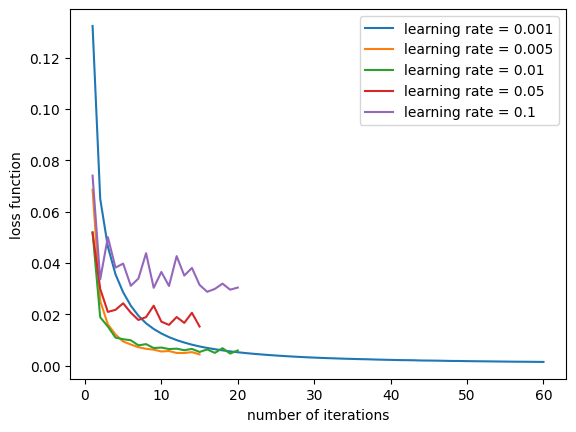

In [13]:
# Learning rate optimization
# ------------
# Test with different learning_rate_init
print("Learning rate optimization")

tests_learning_rate_init = [0.001, 0.005, 0.01, 0.05, 0.1]
activation = 'relu'
random_state = 0

now = datetime.now()
loss_curves =  []
for lr in tests_learning_rate_init:
    mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=lr, shuffle=False, random_state=random_state, verbose=False, activation=activation)
    MLP_train_valid(mlp, features_train, target_train, features_valid, target_valid, max_iter, valid_cycles, False)

    loss_curves.append(mlp.loss_curve_)

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())

# Show results
print("Visualizing the Cost Function Trajectory with different learning rates")
for (lr, loss_curve) in zip(tests_learning_rate_init, loss_curves):
    plt.plot(
        range(1, len(loss_curve) + 1),
        loss_curve,
        label=f'learning rate = {str(lr)}',
    )

plt.xlabel('number of iterations')
plt.ylabel('loss function')
plt.legend(loc='upper right')
plt.show()

Optimizamos la arquitectura del modelo de red neuronal de perceptrón multicapa, combinando distintos parámetros hasta encontrar la arquitectura que ofrezca la mejor precisión en la predicción.

In [16]:
# Architecture optimization
# ------------
print("Architecture optimization")

# Test MLP with differents number of hidden units and several repetitions
tests_n_hidden = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]
n_reps = 10
# n_reps = 20
activation = 'relu'
# activation = 'logistic'
# learning_rate_init = 0.001
# learning_rate_init = 0.01
learning_rate_init = 0.005

now = datetime.now()
best_mlp = []
best_acc = 0.0
accs_train = []
accs_valid = []
for n_hidden in tests_n_hidden:
    max_acc_train = max_acc_valid = 0.0
    for random_state in range(n_reps):
        mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=random_state, verbose=False, activation=activation)
        MLP_train_valid(mlp, features_train, target_train, features_valid, target_valid, max_iter, valid_cycles, False)
        
        acc_train = accuracy_score(target_train, mlp.predict(features_train))
        acc_valid = accuracy_score(target_valid, mlp.predict(features_valid))
        print("Seed = %d, train acc = %.8f, valid acc = %.8f, iterations = %d" % (random_state, acc_train, acc_valid, len(mlp.loss_curve_)))
        if (max_acc_valid < acc_valid):
            max_acc_valid = acc_valid
            max_acc_train = acc_train
            if (acc_valid > best_acc):
                best_acc = acc_valid
                best_mlp = mlp
    accs_train.append(max_acc_train)
    accs_valid.append(max_acc_valid)
    print("Number hidden units = %i, train acc = %.8f, max valid acc = %.8f" % (n_hidden, max_acc_train, max_acc_valid))

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())
print("Best MLP valid accuracy: %.8f%%" % (best_acc * 100))
print("Best MLP: ", best_mlp)

Architecture optimization

Seed = 0, train acc = 0.99160790, valid acc = 0.99098180, iterations = 50

Seed = 1, train acc = 0.99094314, valid acc = 0.99039794, iterations = 65

Seed = 2, train acc = 0.99167121, valid acc = 0.99137573, iterations = 125

Seed = 3, train acc = 0.99377451, valid acc = 0.99301477, iterations = 90

Seed = 4, train acc = 0.99213900, valid acc = 0.99172746, iterations = 115

Seed = 5, train acc = 0.99558940, valid acc = 0.99498442, iterations = 70

Seed = 6, train acc = 0.98139739, valid acc = 0.98171036, iterations = 65

Seed = 7, train acc = 0.98969453, valid acc = 0.98921615, iterations = 75

Seed = 8, train acc = 0.98888557, valid acc = 0.98825946, iterations = 35

Seed = 9, train acc = 0.99123507, valid acc = 0.99061601, iterations = 25

Number hidden units = 10, train acc = 0.99558940, max valid acc = 0.99498442

Seed = 0, train acc = 0.99899759, valid acc = 0.99871269, iterations = 30

Seed = 1, train acc = 0.99844539, valid acc = 0.99791076, iterations = 20

Seed = 2, train acc = 0.99860014, valid acc = 0.99815697, iterations = 20

Seed = 3, train acc = 0.99913476, valid acc = 0.99869159, iterations = 25

Seed = 4, train acc = 0.99770325, valid acc = 0.99735504, iterations = 20

Seed = 5, train acc = 0.99777008, valid acc = 0.99744649, iterations = 25

Seed = 6, train acc = 0.99872676, valid acc = 0.99796000, iterations = 30

Seed = 7, train acc = 0.99897649, valid acc = 0.99848759, iterations = 25

Seed = 8, train acc = 0.99773491, valid acc = 0.99711586, iterations = 15

Seed = 9, train acc = 0.99860014, valid acc = 0.99805848, iterations = 30

Number hidden units = 30, train acc = 0.99899759, max valid acc = 0.99871269

Seed = 0, train acc = 0.99966586, valid acc = 0.99928248, iterations = 25

Seed = 1, train acc = 0.99947945, valid acc = 0.99895186, iterations = 30

Seed = 2, train acc = 0.99922269, valid acc = 0.99869862, iterations = 35

Seed = 3, train acc = 0.99961311, valid acc = 0.99909255, iterations = 30

Seed = 4, train acc = 0.99958497, valid acc = 0.99930359, iterations = 20

Seed = 5, train acc = 0.99969400, valid acc = 0.99924731, iterations = 30

Seed = 6, train acc = 0.99921214, valid acc = 0.99881117, iterations = 25

Seed = 7, train acc = 0.99957793, valid acc = 0.99912069, iterations = 40

Seed = 8, train acc = 0.99966938, valid acc = 0.99926841, iterations = 40

Seed = 9, train acc = 0.99965179, valid acc = 0.99933876, iterations = 25

Number hidden units = 50, train acc = 0.99965179, max valid acc = 0.99933876

Seed = 0, train acc = 0.99961662, valid acc = 0.99917697, iterations = 25

Seed = 1, train acc = 0.99934228, valid acc = 0.99903628, iterations = 20

Seed = 2, train acc = 0.99952869, valid acc = 0.99918400, iterations = 25

Seed = 3, train acc = 0.99944076, valid acc = 0.99909959, iterations = 20

Seed = 4, train acc = 0.99903980, valid acc = 0.99885338, iterations = 25

Seed = 5, train acc = 0.99955683, valid acc = 0.99924028, iterations = 30

Seed = 6, train acc = 0.99977490, valid acc = 0.99931766, iterations = 30

Seed = 7, train acc = 0.99865290, valid acc = 0.99841021, iterations = 10

Seed = 8, train acc = 0.99871270, valid acc = 0.99843835, iterations = 20

Seed = 9, train acc = 0.99894132, valid acc = 0.99877600, iterations = 15

Number hidden units = 70, train acc = 0.99977490, max valid acc = 0.99931766

Seed = 0, train acc = 0.99862828, valid acc = 0.99820621, iterations = 15

Seed = 1, train acc = 0.99933173, valid acc = 0.99891669, iterations = 15

Seed = 2, train acc = 0.99913476, valid acc = 0.99895890, iterations = 10

Seed = 3, train acc = 0.99962014, valid acc = 0.99928952, iterations = 15

Seed = 4, train acc = 0.99973973, valid acc = 0.99946538, iterations = 30

Seed = 5, train acc = 0.99978193, valid acc = 0.99943724, iterations = 20

Seed = 6, train acc = 0.99963773, valid acc = 0.99931062, iterations = 15

Seed = 7, train acc = 0.99963069, valid acc = 0.99924028, iterations = 25

Seed = 8, train acc = 0.99951814, valid acc = 0.99905738, iterations = 15

Seed = 9, train acc = 0.99901166, valid acc = 0.99864235, iterations = 15

Number hidden units = 90, train acc = 0.99973973, max valid acc = 0.99946538

Seed = 0, train acc = 0.99973621, valid acc = 0.99938800, iterations = 25

Seed = 1, train acc = 0.99972214, valid acc = 0.99926138, iterations = 20

Seed = 2, train acc = 0.99927193, valid acc = 0.99894483, iterations = 15

Seed = 3, train acc = 0.99964476, valid acc = 0.99924731, iterations = 15

Seed = 4, train acc = 0.99980304, valid acc = 0.99957090, iterations = 20

Seed = 5, train acc = 0.99965883, valid acc = 0.99930359, iterations = 25

Seed = 6, train acc = 0.99846649, valid acc = 0.99800924, iterations = 25

Seed = 7, train acc = 0.99947593, valid acc = 0.99913476, iterations = 15

Seed = 8, train acc = 0.99947945, valid acc = 0.99919104, iterations = 15

Seed = 9, train acc = 0.99943373, valid acc = 0.99911366, iterations = 20

Number hidden units = 110, train acc = 0.99980304, max valid acc = 0.99957090

Seed = 0, train acc = 0.99962366, valid acc = 0.99916993, iterations = 20

Seed = 1, train acc = 0.99928249, valid acc = 0.99878304, iterations = 20

Seed = 2, train acc = 0.99988041, valid acc = 0.99967641, iterations = 30

Seed = 3, train acc = 0.99978545, valid acc = 0.99948648, iterations = 25

Seed = 4, train acc = 0.99939152, valid acc = 0.99895890, iterations = 10

Seed = 5, train acc = 0.99881469, valid acc = 0.99869159, iterations = 10

Seed = 6, train acc = 0.99893076, valid acc = 0.99852979, iterations = 25

Seed = 7, train acc = 0.99914531, valid acc = 0.99877600, iterations = 25

Seed = 8, train acc = 0.99964828, valid acc = 0.99928248, iterations = 15

Seed = 9, train acc = 0.99973973, valid acc = 0.99950055, iterations = 20

Number hidden units = 130, train acc = 0.99988041, max valid acc = 0.99967641

Seed = 0, train acc = 0.99986635, valid acc = 0.99959200, iterations = 20

Seed = 1, train acc = 0.99972566, valid acc = 0.99940910, iterations = 20

Seed = 2, train acc = 0.99915587, valid acc = 0.99858607, iterations = 15

Seed = 3, train acc = 0.99987690, valid acc = 0.99964828, iterations = 20

Seed = 4, train acc = 0.99979952, valid acc = 0.99954979, iterations = 15

Seed = 5, train acc = 0.99981359, valid acc = 0.99950055, iterations = 20

Seed = 6, train acc = 0.99975731, valid acc = 0.99958497, iterations = 25

Seed = 7, train acc = 0.99966586, valid acc = 0.99944428, iterations = 15

Seed = 8, train acc = 0.99975379, valid acc = 0.99942317, iterations = 15

Seed = 9, train acc = 0.99945483, valid acc = 0.99902924, iterations = 10

Number hidden units = 150, train acc = 0.99987690, max valid acc = 0.99964828

Seed = 0, train acc = 0.99950055, valid acc = 0.99918400, iterations = 15

Seed = 1, train acc = 0.99897297, valid acc = 0.99861421, iterations = 10

Seed = 2, train acc = 0.99965179, valid acc = 0.99950055, iterations = 20

Seed = 3, train acc = 0.99946538, valid acc = 0.99906441, iterations = 30

Seed = 4, train acc = 0.99982062, valid acc = 0.99957793, iterations = 30

Seed = 5, train acc = 0.99912421, valid acc = 0.99881821, iterations = 25

Seed = 6, train acc = 0.99941966, valid acc = 0.99905035, iterations = 15

Seed = 7, train acc = 0.99976083, valid acc = 0.99938097, iterations = 20

Seed = 8, train acc = 0.99980304, valid acc = 0.99945131, iterations = 25

Seed = 9, train acc = 0.99988393, valid acc = 0.99962717, iterations = 25

Number hidden units = 170, train acc = 0.99988393, max valid acc = 0.99962717

Seed = 0, train acc = 0.99964828, valid acc = 0.99936690, iterations = 20

Seed = 1, train acc = 0.99975028, valid acc = 0.99945835, iterations = 20

Seed = 2, train acc = 0.99892021, valid acc = 0.99842428, iterations = 15

Seed = 3, train acc = 0.99983821, valid acc = 0.99945835, iterations = 25

Seed = 4, train acc = 0.99963421, valid acc = 0.99940207, iterations = 30

Seed = 5, train acc = 0.99939152, valid acc = 0.99912772, iterations = 20

Seed = 6, train acc = 0.99970807, valid acc = 0.99947945, iterations = 15

Seed = 7, train acc = 0.99931062, valid acc = 0.99902924, iterations = 15

Seed = 8, train acc = 0.99970807, valid acc = 0.99951462, iterations = 20

Seed = 9, train acc = 0.99989448, valid acc = 0.99966938, iterations = 20

Number hidden units = 190, train acc = 0.99989448, max valid acc = 0.99966938

Number of seconds for training: 2256

Best MLP valid accuracy: 99.96764141%

Best MLP:  MLPClassifier(hidden_layer_sizes=(130,), learning_rate_init=0.005,
              random_state=2, shuffle=False)

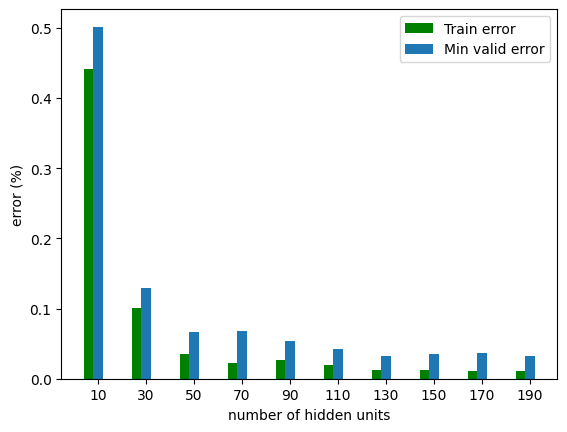

In [17]:
# Show results
width = 4
plt.bar(np.array(tests_n_hidden) - width, 100 *(1- np.array(accs_train)), color='g', width=width, label='Train error')
plt.bar(np.array(tests_n_hidden), 100 *(1- np.array(accs_valid)), width=width, label='Min valid error')
plt.xlabel('number of hidden units')
plt.ylabel('error (%)')
plt.xticks(np.array(tests_n_hidden), tests_n_hidden)
plt.legend(loc='upper right')
plt.show()

In [18]:
# Final results of best MLP
# ------------

print("Printing final results")

predict_train = best_mlp.predict(features_train)
predict_valid = best_mlp.predict(features_valid)
predict_test = best_mlp.predict(features_test)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Test accuracy: %.3f%%" % (accuracy_score(target_test, predict_test) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Test confusion matrix:")
print(confusion_matrix(target_test, predict_test))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))
print("Test classification report:")
print(classification_report(target_test, predict_test))

Printing final results

Train accuracy: 99.988%

Valid accuracy: 99.968%

Test accuracy: 99.962%

Train confusion matrix:

[[142149     24]
 [    10 142132]]

Valid confusion matrix:

[[71089    37]
 [    9 71022]]

Test confusion matrix:

[[70974    42]
 [   12 71130]]

Train classification report:

precision    recall  f1-score   support

           0       1.00      1.00      1.00    142173
           1       1.00      1.00      1.00    142142

    accuracy                           1.00    284315
   macro avg       1.00      1.00      1.00    284315
weighted avg       1.00      1.00      1.00    284315

Valid classification report:

precision    recall  f1-score   support

           0       1.00      1.00      1.00     71126
           1       1.00      1.00      1.00     71031

    accuracy                           1.00    142157
   macro avg       1.00      1.00      1.00    142157
weighted avg       1.00      1.00      1.00    142157

Test classification report:

precision    recall  f1-score   support

           0       1.00      1.00      1.00     71016
           1       1.00      1.00      1.00     71142

    accuracy                           1.00    142158
   macro avg       1.00      1.00      1.00    142158
weighted avg       1.00      1.00      1.00    142158

Printing ROC curves of test set

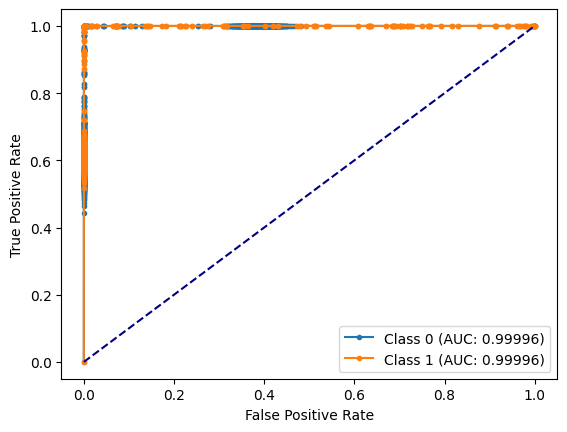

In [19]:
mlp_probs = mlp.predict_proba(features_test)
classes  = np.unique(target_train)
mlp_auc = []
mlp_fpr = []
mlp_tpr = []
for cla in classes:
    mlp_auc.append(roc_auc_score(target_test==cla, mlp_probs[:,cla]))
    fpr, tpr, _ = roc_curve(target_test==cla, mlp_probs[:,cla])
    mlp_fpr.append(fpr)
    mlp_tpr.append(tpr)

print("Printing ROC curves of test set")
# plot the roc curve for the model
for cla in classes:
    # plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(mlp_fpr[cla], mlp_tpr[cla], marker='.', label='Class %d (AUC: %.5f)' % (cla, mlp_auc[cla]))

# axis labels
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [54]:
# Calcular los índices de las filas con predicciones incorrectas
indxs_err = np.where(predict_test != 1)[0]

count_err = np.bincount(indxs_err)
print(count_err)

count = []

for idx in indxs_err:
    pred = predict_test[idx]
    real = target_test.iloc[idx]
    count[pred] += 1
    print("Fila: %d Predicción: %d Real: %d" % (idx, pred, real))

[0 0 0 ... 1 1 1]